# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!


### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
%cd ../data
!wget -O landmark_dataset.zip https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip
!unzip landmark_dataset.zip
%cd ../landmark_project/

/home/iso-9/Workspace/landmark-classification/data
--2021-10-26 19:40:12--  https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip
Resolving udacity-dlnfd.s3-us-west-1.amazonaws.com (udacity-dlnfd.s3-us-west-1.amazonaws.com)... 52.219.117.162
Connecting to udacity-dlnfd.s3-us-west-1.amazonaws.com (udacity-dlnfd.s3-us-west-1.amazonaws.com)|52.219.117.162|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 751872692 (717M) [application/zip]
Saving to: ‘landmark_dataset.zip’

landmark_dataset.zi   0%[                    ]       0  --.-KB/s               ^C
Archive:  landmark_dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of landmark_dataset.zip or
        landmark_dataset.zip.zip, and

In [32]:
import time

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.functional as F
import torch.nn as nn

from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import datasets, models, transforms

%matplotlib inline

In [2]:
params = {
  "TEST_SIZE": 0.2,
  "BATCH_SIZE": 32,
  "SEED": 42
}

In [13]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

loaders_scratch = {'train': None, 'valid': None, 'test': None}

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(size=(224, 224)),
                                transforms.RandomHorizontalFlip(0.2),
                                transforms.RandomRotation(10),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([transforms.Resize(size=(224, 224)), 
                                       transforms.ToTensor(), 
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = datasets.ImageFolder("../data/landmark_images/train", transform=transform)
test_dataset = datasets.ImageFolder("../data/landmark_images/test", transform=test_transform)

targets = train_dataset.targets
train_idx, validation_idx = train_test_split(
    np.arange(len(targets)),
    test_size=params['TEST_SIZE'],
    shuffle=True,
    random_state=params['SEED'],
    stratify=targets)

# generate subset based on indices
train_split = Subset(train_dataset, train_idx)
validation_split = Subset(train_dataset, validation_idx)

loaders_scratch['train'] = DataLoader(train_split, batch_size=params['BATCH_SIZE'])
loaders_scratch['valid'] = DataLoader(validation_split, batch_size=params['BATCH_SIZE'])
loaders_scratch['test'] = DataLoader(test_dataset, batch_size=params['BATCH_SIZE'])

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
classes = [item[3:].replace("_", " ") for item in train_dataset.classes]

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 
* The resize was done using transform.Resize to 224 because on average the size of images because it is standard practice. Also the resizing is necessary because images are of variable length.
* Yes, I added the augmentations using horizontal_flip and rotation because in real world it is possible that images are not provided as in trainig data. It completely unpredictable what type of image is pased to the model.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


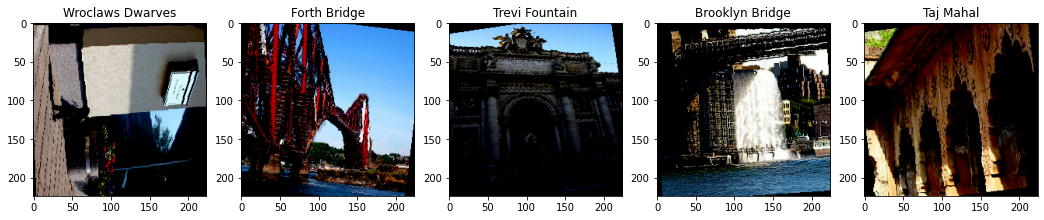

In [27]:
## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
images = iter(loaders_scratch['train'])
images, labels = next(images)

fig, axs = plt.subplots(1, 5, figsize=(18, 16),)

for idx, (img, lbl) in enumerate(list(zip(images, labels))[:5]):
    img = img.numpy()

    # get one image from the batch
    img = np.squeeze(img).transpose((1,2,0))

    axs[idx].imshow(img)
    axs[idx].title.set_text(classes[lbl])

plt.show()

### Initialize use_cuda variable

In [29]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()

/home/iso-9/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [6]:
## TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return optimizer    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [8]:
import torch.nn as nn

# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        in_1 = 64
        in_2 = 128
        in_3 = 256
        in_4 = 512

        ## Define layers of a CNN
        self.conv_1 = nn.Conv2d(3, in_1, 3, padding=1)
        # 112
        self.conv_2 = nn.Conv2d(in_1, in_2, 3, padding=1)
        # 56
        self.conv_3 = nn.Conv2d(in_2, in_3, 3, padding=1)
        # 28
        self.conv_4 = nn.Conv2d(in_3, in_4, 3, padding=1)
        # 14

        self.pool = nn.MaxPool2d(2, 2)
        self.droput = nn.Dropout(0.5)
        
        in_size = 14 * 14 * in_4
        self.fc1 = nn.Linear(in_size, 512)
        self.fc2 = nn.Linear(512, 50)

        self.relu = nn.ReLU()

        
    def forward(self, x):
        ## Define forward behavior
        batch_size = x.size()[0]

        x = self.pool(self.relu(self.conv_1(x)))
        x = self.pool(self.relu(self.conv_2(x)))
        x = self.pool(self.relu(self.conv_3(x)))
        x = self.pool(self.relu(self.conv_4(x)))

        x = x.view(batch_size, -1)

        x = self.droput(x)
        x = self.relu(self.fc1(x))
        x = self.droput(x)
        x = self.fc2(x)
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

model_scratch

Net(
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (droput): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=50, bias=True)
  (relu): ReLU()
)

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  
1. Decided to increase the channels gradually to capture the features.
2. Kept 4 layers in the architecture for nn to be deep enough to capture the features and not deep enough to overfit.
3. Introduced pooling layer to keep the size of model in check and avoid over fitting
4. We add two fully connected layer to learn for classification
5. Droput to avoid overfitting layer
6. Activation fucntion as RELU because it performs generally well

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [8]:

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        start_time = time.time()
        
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
            optimizer.zero_grad()

            output = model(data)
            loss = criterion_scratch(output, target)

            loss.backward()
            optimizer.step()
            
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

        torch.cuda.empty_cache()
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion_scratch(output, target)

            ## TODO: update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

        total_time = start_time - time.time()
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}. Time taken {}'.format(
            epoch, 
            train_loss,
            valid_loss,
            total_time
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            print(f"Validationn loss reduced from {valid_loss_min: .6f} to{valid_loss: .6f}, saving model")
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [9]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0]*m.kernel_size[1]*m.in_channels
        y = 1 / np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    elif isinstance(m, nn.Linear):
        y = 1/ np.sqrt(m.in_features)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)

#-#-# Do NOT modify the code below this line. #-#-#

model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'ignore.pt')

Epoch: 1 	Training Loss: 3.867903 	Validation Loss: 3.702778. Time taken -63.707558393478394
Validationn loss reduced from  inf to 3.702778, saving model
Epoch: 2 	Training Loss: 3.624093 	Validation Loss: 3.465199. Time taken -63.99508762359619
Validationn loss reduced from  3.702778 to 3.465199, saving model
Epoch: 3 	Training Loss: 3.413339 	Validation Loss: 3.326944. Time taken -63.88941240310669
Validationn loss reduced from  3.465199 to 3.326944, saving model
Epoch: 4 	Training Loss: 3.221277 	Validation Loss: 3.159111. Time taken -63.86681127548218
Validationn loss reduced from  3.326944 to 3.159111, saving model
Epoch: 5 	Training Loss: 3.012082 	Validation Loss: 3.063202. Time taken -63.91702914237976
Validationn loss reduced from  3.159111 to 3.063202, saving model
Epoch: 6 	Training Loss: 2.796825 	Validation Loss: 2.936380. Time taken -63.88452458381653
Validationn loss reduced from  3.063202 to 2.936380, saving model
Epoch: 7 	Training Loss: 2.626273 	Validation Loss: 2.88

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [11]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 22

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.852005 	Validation Loss: 3.642867. Time taken -63.841986656188965
Validationn loss reduced from  inf to 3.642867, saving model
Epoch: 2 	Training Loss: 3.566952 	Validation Loss: 3.423414. Time taken -63.82070064544678
Validationn loss reduced from  3.642867 to 3.423414, saving model
Epoch: 3 	Training Loss: 3.378457 	Validation Loss: 3.303780. Time taken -64.29261445999146
Validationn loss reduced from  3.423414 to 3.303780, saving model
Epoch: 4 	Training Loss: 3.249524 	Validation Loss: 3.221670. Time taken -64.24712061882019
Validationn loss reduced from  3.303780 to 3.221670, saving model
Epoch: 5 	Training Loss: 3.074245 	Validation Loss: 3.114138. Time taken -64.27734565734863
Validationn loss reduced from  3.221670 to 3.114138, saving model
Epoch: 6 	Training Loss: 2.907147 	Validation Loss: 3.020241. Time taken -64.06990814208984
Validationn loss reduced from  3.114138 to 3.020241, saving model
Epoch: 7 	Training Loss: 2.759951 	Validation Loss: 2.98

### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.642789


Test Accuracy: 37% (463/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [18]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

params['BATCH_SIZE'] = 64

loaders_transfer = {'train': None, 'valid': None, 'test': None}

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Resize(size=(224, 224)),
                                transforms.RandomHorizontalFlip(0.2),
                                transforms.RandomRotation(10),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder("../data/landmark_images/train", transform=transform)
test_dataset = datasets.ImageFolder("../data/landmark_images/test", transform=transform)

targets = train_dataset.targets
train_idx, validation_idx = train_test_split(
    np.arange(len(targets)),
    test_size=params['TEST_SIZE'],
    shuffle=True,
    random_state=params['SEED'],
    stratify=targets)

# generate subset based on indices
train_split = Subset(train_dataset, train_idx)
validation_split = Subset(train_dataset, validation_idx)

loaders_transfer['train'] = DataLoader(train_split, batch_size=params['BATCH_SIZE'])
loaders_transfer['valid'] = DataLoader(validation_split, batch_size=params['BATCH_SIZE'])
loaders_transfer['test'] = DataLoader(test_dataset, batch_size=params['BATCH_SIZE'])

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [19]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    return optimizer   


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [20]:
## TODO: Specify model architecture

model_transfer = models.resnet18(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False

num_in_features = model_transfer.fc.in_features
model_transfer.fc = nn.Sequential(
                        nn.Linear(num_in_features, 512),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(512, 50),
                )
    
#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__
1. I chose Resnet18 for transfer learning as it provides robust outcomes and is predominant in industry
2. I freeze the parameters for finetuning of the network
3. At last I replace linear layer with two fully connected layers and change parameters according to our use case.
4. Shift model to Cuda

The model is suitable for current problem becasue Residual Networks try to cover deeper relationships between the features and resnet18 is also the smallest of the breed which is suitable for our use case for now

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'

def train_transfer(*, model, criterion, loaders, epochs=1, optimizer):
    epochs = epochs

    epoch_running_train_loss = []
    epoch_running_validation_loss = []
    best_validation_loss = np.Inf

    for epoch in range(epochs):
        start_time = time.time()

        batch_train_loss = 0.0
        batch_validation_loss = 0.0
        
#         print("In batch")
        model.train()
        for inputs, labels in loaders['train']:
            
            if use_cuda:
                inputs, labels = inputs.cuda(), labels.cuda()

            model.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            batch_train_loss += loss.item() * inputs.size(0)

            loss.backward()
            optimizer.step()
            
#         print("In validation")
        model.eval()
        with torch.no_grad():
            for inputs, labels in loaders['valid']:
                if use_cuda:
                    inputs, labels = inputs.cuda(), labels.cuda()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                batch_validation_loss += loss.item() * inputs.size(0)
        
        epoch_train_loss = batch_train_loss/len(loaders['train'].dataset)
        epoch_validation_loss = batch_validation_loss/len(loaders['valid'].dataset)
        
        print(f"Epoch {epoch} || Training Loss = {epoch_train_loss} || Validation Loss = {epoch_validation_loss} || Time taken {start_time - time.time()}")
        
        epoch_running_train_loss.append(epoch_train_loss)
        epoch_running_validation_loss.append(epoch_validation_loss)

        if best_validation_loss > epoch_validation_loss:
            print("Validation loss decreased .. saving model ..")
            torch.save(model.state_dict(), 'model_transfer.pt')
            best_validation_loss = epoch_validation_loss
    
    return epoch_running_train_loss, epoch_running_validation_loss
        
losses = train_transfer(model=model_transfer, epochs=70, loaders=loaders_transfer, optimizer=get_optimizer_transfer(model_transfer), criterion=criterion_transfer)


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch 0 || Training Loss = 3.871344980192626 || Validation Loss = 3.7193381042480467 || Time taken -59.960062742233276
Validation loss decreased .. saving model ..
Epoch 1 || Training Loss = 3.625741354608524 || Validation Loss = 3.4559649333953857 || Time taken -59.98501014709473
Validation loss decreased .. saving model ..
Epoch 2 || Training Loss = 3.35288367887005 || Validation Loss = 3.1504970111846924 || Time taken -59.993042945861816
Validation loss decreased .. saving model ..
Epoch 3 || Training Loss = 3.059916733681395 || Validation Loss = 2.8490817451477053 || Time taken -60.02262854576111
Validation loss decreased .. saving model ..
Epoch 4 || Training Loss = 2.7950583204556203 || Validation Loss = 2.5800041694641114 || Time taken -59.938199043273926
Validation loss decreased .. saving model ..
Epoch 5 || Training Loss = 2.5615683797898816 || Validation Loss = 2.3797419395446777 || Time taken -60.02009415626526
Validation loss decreased .. saving model ..
Epoch 6 || Trainin

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [22]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.113806


Test Accuracy: 70% (883/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [41]:
# pu model in eval mode
model_transfer.eval()

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    img = Image.open(img_path)
    img = transform(img)
    img = img.unsqueeze(0)
    
    if use_cuda:
        img = img.cuda()
        
    
    output = model_transfer(img)
    top_probs, top_prods_idx = output.topk(k)
    
    preds = np.squeeze(top_prods_idx.numpy()) if not use_cuda else np.squeeze(top_prods_idx.cpu().numpy())
    
    names =[]
    for pred in preds:
        names.append(classes[pred])
    
    return names


# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Forth Bridge',
 'Dead Sea',
 'Brooklyn Bridge',
 'Monumento a la Revolucion']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

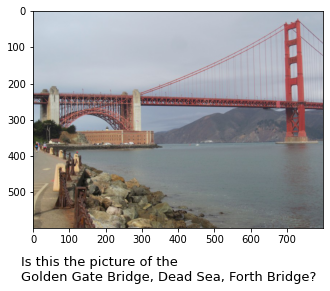

In [42]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    txt = 'Is this the picture of the \n' + ", ".join(predicted_landmarks) + "?"
    
    ## TODO: display image and display landmark predictions
    plt.imshow(Image.open(img_path))
    plt.figtext(0.15, -0.05, txt, wrap=True, horizontalalignment='left', fontsize=13)
    

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

It is better than what I expected. Transfer Learning has given the tremendous boost :)

**How to improve?**
- Better hyperparameters (tuning)
- Finetune model with already trained model which had related training data
- Experiment with model layers

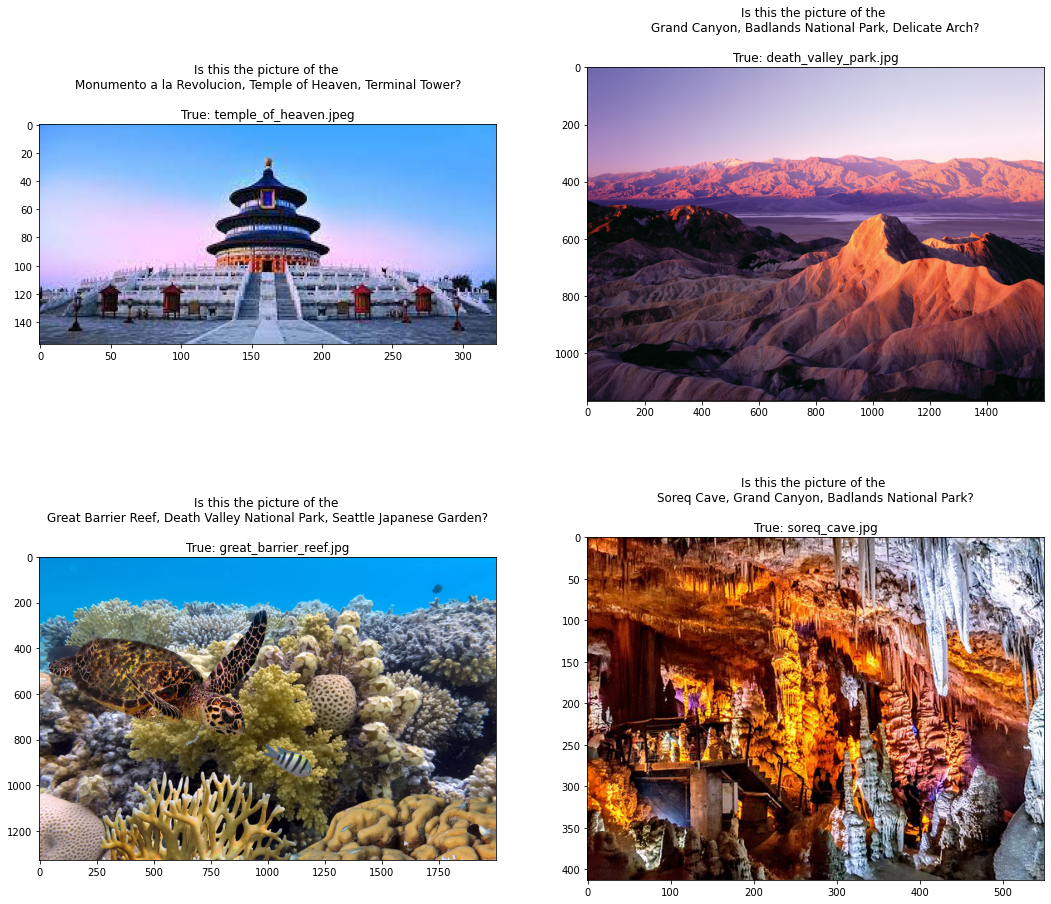

In [43]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
from pathlib import Path

paths = [x for x in Path("test_images/").glob("*")]

from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 2, figsize=(18, 16), )

for idx, each in enumerate(paths):
    predicted_landmarks = predict_landmarks(each, 3)
    txt = 'Is this the picture of the \n' + ", ".join(predicted_landmarks) + "?" + "\n\nTrue: " + str(each).rsplit('/',1)[-1]
    
    axs[idx//2][idx%2].imshow(Image.open(each))
    axs[idx//2][idx%2].title.set_text(txt)

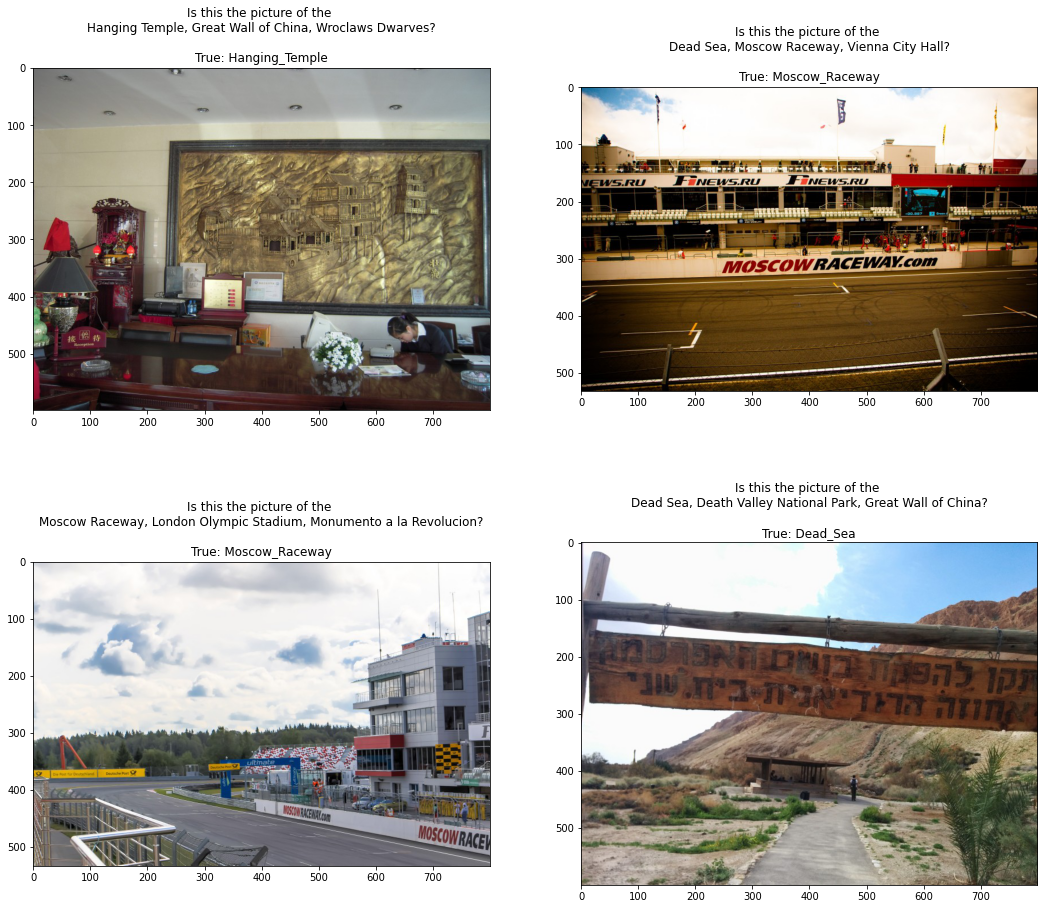

In [45]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
from pathlib import Path

paths = [x for x in Path("../data/landmark_images/test/").glob("*/*.jpg")]

paths = [paths[i] for i in np.random.choice(len(paths), size=4)]
paths

from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 2, figsize=(18, 16), )

for idx, each in enumerate(paths):
    predicted_landmarks = predict_landmarks(each, 3)
    txt = 'Is this the picture of the \n' + ", ".join(predicted_landmarks) + "?" + "\n\nTrue: " + str(each).rsplit('/',2)[-2].split(".")[-1]
    
    axs[idx//2][idx%2].imshow(Image.open(each))
    axs[idx//2][idx%2].title.set_text(txt)